In [ ]:
%matplotlib inline
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

def show_datamodule(dm, batch_type):
    dm.prepare_data()
    dm.setup(stage='fit')
    train_dl = dm.train_dataloader()
    for i, batch in enumerate(train_dl):
        batch = batch[batch_type]
        for j in range(2):
            f, ax = plt.subplots(ncols=2, figsize=(20,12))
            ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
            #ax[0].set_title(batch['image_path'][j])
            if batch_type=='sup':
                ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
                #ax[1].set_title(batch['label_path'][j])
        plt.show()  
        break

### FLAIR

In [ ]:
%load_ext autoreload
%autoreload 2  
%matplotlib inline
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

dm = datamodules.Flair(
    #data_path='/work/AI4GEO/users/fournip',
    data_path='/data',
    #data_path='/scratchm/pfournie/data',
    merge='hierarchical6',
    sup=3,
    unsup=5,
    bands=[1,2,3],
    dataset_tf=tf.StretchToMinmax([0]*3, [255]*3),
    batch_size=2,
    num_workers=4,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')
train_dl = dm.train_dataloader()
for i, batch in enumerate(train_dl):
    batch_type='unsup'
    batch = batch[batch_type]
    for j in range(2):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        #ax[0].set_title(batch['image_path'][j])
        if batch_type=='sup':
            ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
            #ax[1].set_title(batch['label_path'][j])
    plt.show()  
    break

### PSEUDOSUP FLAIR

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import FlairPseudosup
import dl_toolbox.transforms as tf
from pathlib import Path
import torch

pl_dir = Path('/data/outputs/flair2_3_97/supervised_dummy/2023-09-05_102306/checkpoints/last_preds')  

dm = FlairPseudosup(
    data_path='/data',
    merge='hierarchical6',
    sup=3,
    unsup=0,
    bands=[1,2,3],
    dataset_tf=tf.StretchToMinmax([0]*3, [255]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    pl_dir=pl_dir,
    thresh=10
)

show_datamodule(dm, 'sup')

### Digitanie

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1688
28


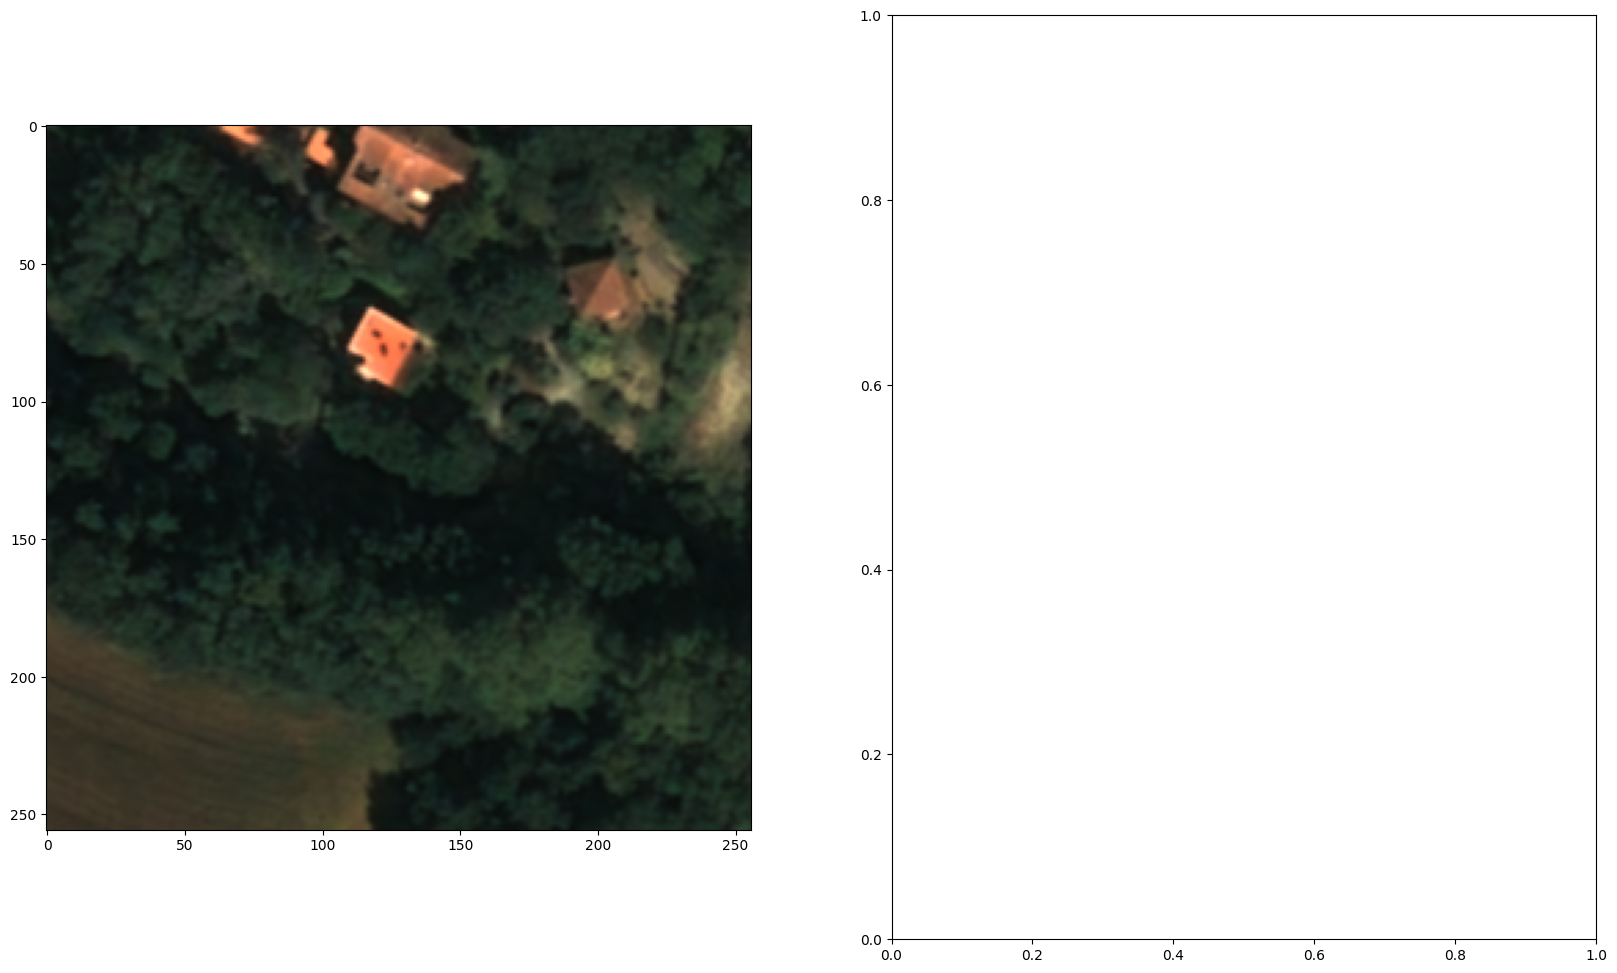

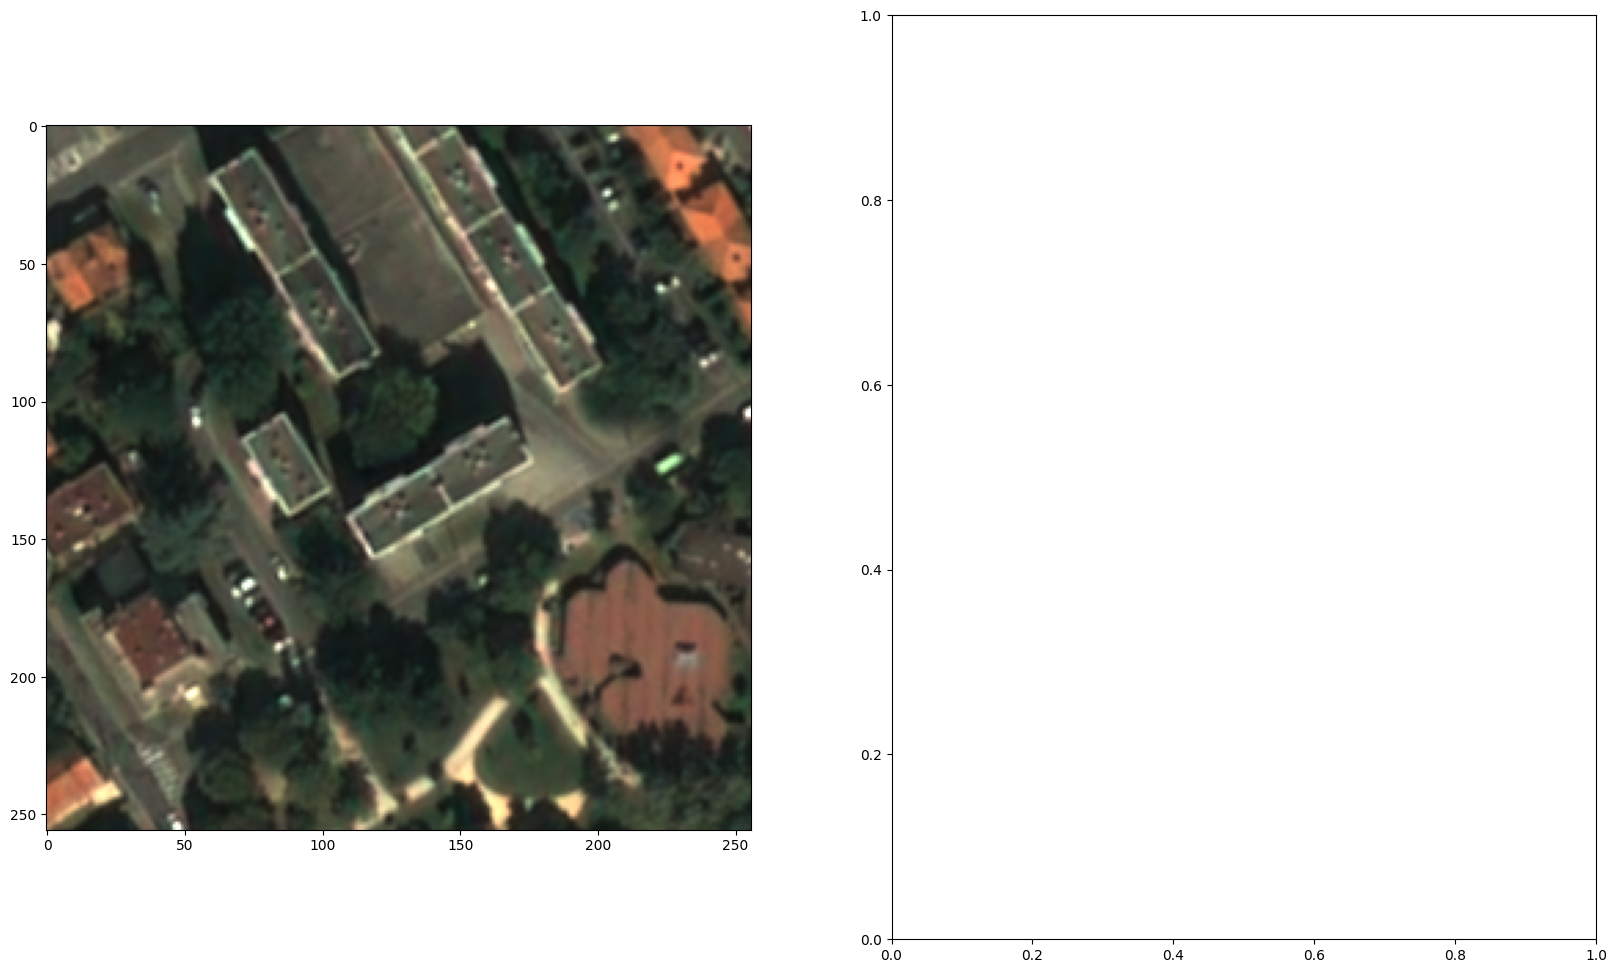

In [11]:
%load_ext autoreload
%autoreload 2  
%matplotlib inline
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb 
from functools import partial
from pathlib import Path
import rasterio

data = '/work/AI4GEO/data/DATA/DATASETS'
data = '/data'
#t = Path(data)/'DIGITANIE_v4/ARCACHON/ARCACHON_20180821_T_16bits_COG.tif'
#with rasterio.open(t) as f:
#    print(list(f.block_windows())[:10])

dm = datamodules.Digitanie(
    city='TOULOUSE',
    data_path=data,
    merge='main5',
    bands=[1,2,3],
    #dataset_tf=tf.StretchToMinmax([0]*3, [3000]*3),
    sup=4,
    unsup=1,
    #train_tf=partial(
    #    tf.NormalizeFromNpy,
    #    npy=data+'/DIGITANIE_v4/normalisation_stats.npy',
    #    min_p='2',
    #    max_p='995',
    #    bands=[1,2,3]
    #),
    to_0_1=tf.To_0_1([0]*3, [3000]*3),
    train_tf=tf.NoOp(),
    test_tf=tf.NoOp(),
    batch_size_s=4,
    batch_size_u=4,
    steps_per_epoch=250,
    num_workers=0,
    pin_memory=False
)
dm.prepare_data()
dm.setup(stage='fit')
print(len(dm.train_s_set))

dl = dm.train_dataloader()
for i, batch in enumerate(dl):
    batch_type='unsup'
    batch = batch[batch_type]
    for j in range(2):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        #ax[0].set_title(batch['image_path'][j])
        if batch_type=='sup':
            ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
            #ax[1].set_title(batch['label_path'][j])
    plt.show()  
    break

In [ ]:
%timeit

### Digi semisup

In [ ]:
%load_ext autoreload
%autoreload 2  

dm = datamodules.DigitanieCitySemisup(
    data_path='/work/AI4GEO/data/DATA/DATASETS',
    city='TOULOUSE',
    sup=80,
    unsup=1,
    merge='all9',
    bands=[1,2,3],
    dataset_tf=tf.StretchToMinmax([0]*3, [8000.]*3),
    batch_size=4,
    num_workers=0,
    pin_memory=False
)

show_datamodule(dm, 'sup')
show_datamodule(dm, 'unsup')

### RESISC

In [ ]:
%load_ext autoreload
%autoreload 2  
%matplotlib inline
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb
import torch.nn.functional as F
import dl_toolbox.datasets as datasets

transforms = tf.Compose([
    #tf.D4(),
    tf.RandomCrop2(size=256),
    tf.Color([0.6,1.4]),
    tf.D4(),
    #tf.RandomResizedCrop(size=224, scale=(0.8,1), ratio=(0.8,1.2)),
    #tf.StretchToMinmax([0]*3, [255]*3)
])

dm = datamodules.Resisc(
    #data_path='/work/AI4GEO/users/fournip',
    #data_path='/scratchm/pfournie/data',
    data_path='/data',
    merge='all45',
    sup=1,
    unsup=4,
    bands=[1,2,3],
    #dataset_tf=tf.StretchToMinmax([0]*3, [255.]*3),
    train_tf=transforms,
    test_tf=transforms,
    batch_size_s=4,
    batch_size_u=8,
    steps_per_epoch=250,
    num_workers=0,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')
dl = dm.train_dataloader()
print(len(dm.train_s_set)/45)

for i, batch in enumerate(dl):
    batch = batch['sup']
    xs = batch["image"]
    ys = batch["label"]
    ys_o = F.one_hot(ys.unsqueeze(1), 45).transpose(1,-1).squeeze(-1).float()
    xs, ys_o = tf.Cutmix(0.4)(xs, ys_o)
    for j in range(4):
        f, ax = plt.subplots(ncols=1, figsize=(6,6))
        ax.imshow(xs[j].numpy().transpose(1,2,0))
        ax.set_title([(datasets.Resisc.classes['all45'].value[i].name, val) for i,val in enumerate(ys_o[j]) if val!=0])
    plt.show()  
    break

### Pseudosup resisc

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import ResiscPseudosup
import dl_toolbox.transforms as tf

  
dm = ResiscPseudosup(
    data_path='/data',
    merge='all45',
    sup=3,
    unsup=0,
    dataset_tf=tf.StretchToMinmax([0]*3, [255.]*3),
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    pl_dir='/data/outputs/resisc_3_80/sup/2023-09-05_154623/checkpoints/last_preds',
    thresh=4000
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['pseudosup']
    for j in range(4):
        f, ax = plt.subplots(ncols=1, figsize=(6,6))
        ax.imshow(batch['image'][j].numpy().transpose(1,2,0))
        ax.set_title(batch['label'][j])
    plt.show()  
    break

### Semcity

In [ ]:
%load_ext autoreload

%autoreload 2  
%matplotlib inline
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb 
from functools import partial
import torch

transforms = tf.Compose([
    #v2.ToDtype(torch.uint8),  # optional, most input are already uint8 at this point
    tf.D4(),
    tf.RandomCrop2(size=256),
    tf.RandomResizedCrop(size=256, scale=(0.8,1), ratio=(0.8,1.2)),
    #tf.StretchToMinmax([0]*3, [255]*3)
    tf.Color([0.5,1.5])
    #v2.RandomResizedCrop(size=224, scale=(1,1), ratio=(1,1), antialias=True),# Or Resize(antialias=True)
    #v2.ToDtype(torch.float32),  # Normalize expects float input
    #v2.ColorJitter(hue=0.3),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
  
dm = datamodules.Semcity(
    #data_path='/scratchm/pfournie/data',
    #data_path='/work/AI4GEO/users/fournip',
    data_path="/data",
    merge='main5',
    bands=[1,2,3],
    sup=1,
    unsup=1,
    train_tf=transforms,
    test_tf=transforms,
    #dataset_tf=tf.Compose([
    #    tf.Resize([0.5]),
    #    tf.RandomCrop2(256),
    #    tf.StretchToMinmax([0]*3, [255]*3)
    #]),
    #dataset_tf=tf.StretchToMinmaxFromCsv(
    #    csv='~/dl_toolbox/dl_toolbox/datasets/semcity/semcity_stats.csv',
    #    min_p='p0.0',
    #    max_p='p99.0',
    #    bands=[1,2,3]
    #),
    batch_size_s=4,
    batch_size_u=8,
    steps_per_epoch=250,
    num_workers=0,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')
train_dl = dm.train_dataloader()
for i, batch in enumerate(train_dl):
    batch_type='sup'
    batch = batch[batch_type]
    for j in range(4):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        #ax[0].set_title(batch['image_path'][j])
        if batch_type=='sup':
            ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
            #ax[1].set_title(batch['label_path'][j])
    plt.show()  
    break

### Semcity Pseudosup not implemented

### AIRS

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import Airs
import dl_toolbox.transforms as tf

  
dm = Airs(
    data_path='/work/AI4GEO/data/DATA/DATASETS',
    filter_path='/work/AI4GEO/users/fournip/AIRS/train.csv',
    merge='building',
    bands=[1,2,3],
    sup=3,
    unsup=5,
    dataset_tf=tf.StretchToMinmax([0]*3, [255.]*3),
    batch_size=4,
    num_workers=0,
    pin_memory=False
)

show_datamodule(dm, 'unsup')

### CITYSCAPES

In [ ]:
%load_ext autoreload
%autoreload 2  
%matplotlib inline
import dl_toolbox.datamodules as datamodules
import dl_toolbox.transforms as tf
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb
from dl_toolbox.datamodules import Cityscapes
import dl_toolbox.transforms as tf

  
dm = Cityscapes(
    data_path='/data',
    merge='all19',
    sup=3,
    unsup=5,
    dataset_tf=tf.NoOp(),
    batch_size=2,
    num_workers=0,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['sup']
    for j in range(2):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
        for l in range(2):
            ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  
    break